# Naive search
Naive search uses string-by-string lookup, with the best search time of `O(stings+query)`. Indexing allows to break this linear dependency. But we will start with naive search.

Start your journey with unpacking `../datasets/nlp/JEOPARDY_CSV.zip`.

In [1]:
from time import time
import csv

Let's use a single query for all experiments.

In [2]:
query = "African country"

Reading the dataset as the list of questions (only).

In [3]:
start = time()
dataset = []
with open('../datasets/nlp/JEOPARDY_CSV.csv', newline='', encoding='utf8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        dataset.append(row[5])
stop = time()
print(f"Dataset load time: {stop - start:.3f} sec.")
print("Dataset length:", len(dataset))
print("Example:", dataset[1000])

Dataset load time: 0.691 sec.
Dataset length: 216931
Example: In September 1999 an abridged version of his "City of God" ranked 9,821st on Amazon.com's sales list


We will produce few scaled versions of the dataset. 

**NB** You can add bigger sizes into the list, but this will require significant time for some experiments.

In [5]:
datasets = [dataset * k for k in [1, 2, 5]]
dataset_sizes = [len(d) for d in datasets]

## Naive implementation of substring search

*TODO:*
Implement a naive search of a substring in the list.

In [6]:
def naive_search(dataset, query):
    '''
    Method accepts a `dataset` -- list of strings
    And a `query` - string.
    It should return a list of dataset ROW NUMBERS as a result.
    '''
    result = []
    
    for i, line in enumerate(dataset):
        if query in line:
            result.append(i)
    
    return result

Let's measure 2 most important things about the search: how accuarate it is, and how fast.

In [7]:
naive_timings = []
naive_results = []

for dataset in datasets:
    start = time()
    res = naive_search(dataset, query)
    stop = time()
    naive_results.append(res)
    naive_timings.append(stop - start)

### Measuring precision
`precision = (true detections) / (all detections)`

In [38]:
def precision(reference, serp, over=100, c=1):
    return min(1, len(set(serp[:int(c * over)]).intersection(reference)) / min(over, len(reference)))

In [36]:
import matplotlib.pyplot as plt

def plot_precision(ref_results, results, c=1):
    over = [10, 20, 50, 100]
    for i, ref in enumerate(ref_results):
        precisions = [
            precision(ref, results[i], c=c)
            for k in over
        ]
        plt.plot(over, precisions, label=f"|DS|={len(datasets[i])}")
    plt.xlabel("@K")
    plt.ylabel("precision")
    plt.legend()
    plt.show()

Obviously, if we compare to itself, we obtain 100%.

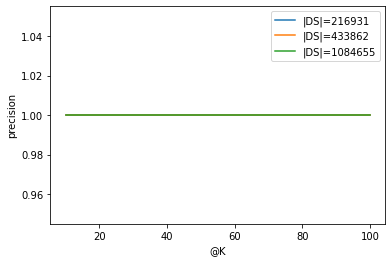

In [31]:
plot_precision(naive_results, naive_results)

### Measuring time

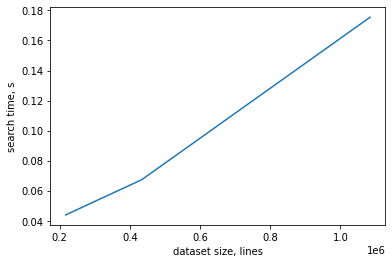

In [11]:
import matplotlib.pyplot as plt
plt.plot(dataset_sizes, naive_timings)
plt.xlabel("dataset size, lines")
plt.ylabel("search time, s")
plt.show()

## How about inverted indexing?

Let's start with important imports

In [ ]:
!pip install tqdm

In [12]:
# nltk - toolkit for natural language. Will do tokenization and stemming for us.
import nltk
from nltk import tokenize
from nltk.stem.snowball import SnowballStemmer

# progress visualization
from tqdm import tqdm 

# as we upscale the dataset with repetition, we can utilize this to avoid recomputing
STEM_CACHE = dict()

This function produces stems out of the original sentence.

In [14]:
def to_stems(dataset, silent=False):
    global STEM_CACHE
    stemmer = SnowballStemmer("english")
    lexemes = []
    for line in tqdm(dataset, disable=silent):
        if line in STEM_CACHE:
            lex = STEM_CACHE[line]
        else:
            lex = [stemmer.stem(word) 
                    for word
                    in tokenize.word_tokenize(line.lower())
                    if word not in (',', '.', ':', '-', ';', '?', '!', '"', "``", "`", "''", "'")
                ]
            STEM_CACHE[line] = lex
        lexemes.append(lex)
    return lexemes

In [15]:
lex_datasets = []
for dataset in datasets:
    lex_datasets.append(to_stems(dataset))

100%|███████████████████████████████████████████████████████████████████| 1084655/1084655 [00:00<00:00, 1129346.86it/s]


Let's check what is stem representation for the string

In [20]:
print("Was:\t", datasets[0][105])
print("Is:\t", lex_datasets[0][105])

Was:	 Of the 6 noble gases on the periodic table, it is the lightest
Is:	 ['of', 'the', '6', 'nobl', 'gase', 'on', 'the', 'period', 'tabl', 'it', 'is', 'the', 'lightest']


Inverted index uses **stems** as _keys_ and **document numbers** (lists of documents which contain this stem) as _values_.

In [21]:
def construct_lookup(lexemes, silent=False):
    result = dict()
    # for each text representation
    for i, lx in enumerate(tqdm(lexemes, disable=silent)):
        # for each lexeme in text
        for lexeme in lx:
            # if first met
            if lexeme not in result: result[lexeme] = set()
            # add text index to posting list
            result[lexeme].add(i)
    return result

In [22]:
ivfs = []
for lexemes in lex_datasets:
    ivfs.append(construct_lookup(lexemes))

100%|████████████████████████████████████████████████████████████████████| 1084655/1084655 [00:08<00:00, 125734.71it/s]


_TODO:_
Complete the search procedure. We iterate through the stems of the query and keep only those documents, which are present in all of them. In other words, we seek for intersection of all posting lists, corresponding to the query stems.

In [32]:
def ivf_search(index, query):
    res = None
    stems = set(to_stems([query], silent=True)[0])
    for stem in stems:
        if stem not in index:
            continue
        if res is None: res = index[stem]
        else: res = index[stem] & res
    return list(res)

In [25]:
r = ivf_search(ivfs[0], query)
print(datasets[0][r[0]])

The African country of Burkina Faso was once known as "Upper" this


Let's check if it works ok.

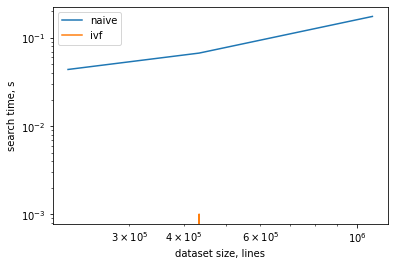

In [27]:
ivf_timings = []
ivf_results = []
for ivf in ivfs:
    start = time()
    res = ivf_search(ivf, query)
    stop = time()
    ivf_timings.append(stop - start)
    ivf_results.append(res)
    
plt.plot(dataset_sizes, naive_timings, label="naive")
plt.plot(dataset_sizes, ivf_timings, label="ivf")
plt.xlabel("dataset size, lines")
plt.ylabel("search time, s")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

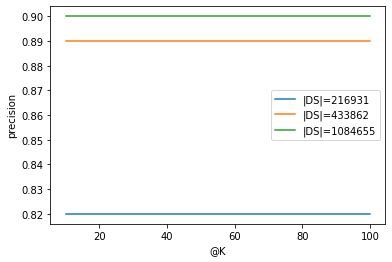

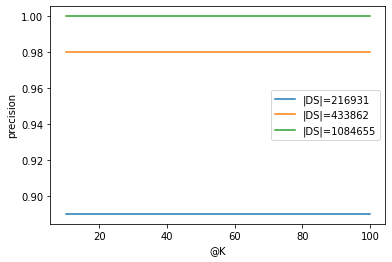

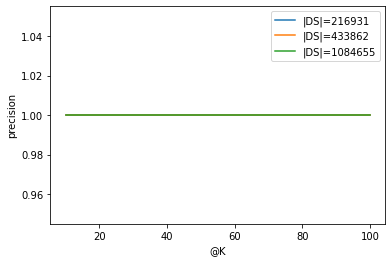

In [40]:
plot_precision(naive_results, ivf_results, c=1)
plot_precision(naive_results, ivf_results, c=1.1)
plot_precision(naive_results, ivf_results, c=2)

*TODO:* How can you explain non-perfect results for smaller `c`?

## Vector representations

_TODO:_ Download https://sprotasov.ru/files/rapid/vector_cache.pkl if you don't want to run embedding process yourself (~10 min).

In [41]:
!pip install spacy
!python -m spacy download en_core_web_md
!pip install pickle

from IPython.display import clear_output
clear_output()

Load embedding model and initialize the cache.

In [42]:
import spacy
import os
import pickle
spacy_model = spacy.load('en_core_web_md')

VEC_CACHE = dict() 

Either load vectors from the file, or generate them with the model.

In [43]:
if not os.path.exists('vector_cache.pkl'):
    VEC_CACHE = dict() 
else:
    with open('vector_cache.pkl', 'rb') as f:
        VEC_CACHE = pickle.load(f)


def to_vectors(dataset, silent=False):
    global VEC_CACHE
    vectors = []
    for line in tqdm(dataset, disable=silent):
        if line in VEC_CACHE:
            v = VEC_CACHE[line]
        else:
            v = spacy_model(line).vector
            VEC_CACHE[line] = v
        vectors.append(v)
    return vectors

Prepare embedding lists for all dataset sizes.

In [44]:
vec_datasets = []
for dataset in datasets:
    vec_datasets.append(to_vectors(dataset))

100%|███████████████████████████████████████████████████████████████████| 1084655/1084655 [00:00<00:00, 1421721.65it/s]


## Saving embedding
Embedding of the dataset can take ~30 minutes. Thus you can simplr load CACHE from the file.

In [45]:
import pickle
if not os.path.exists('vector_cache.pkl'):
    with open("vector_cache.pkl", 'wb') as f:
        pickle.dump(VEC_CACHE, f)

## Annoy Vector Index
https://github.com/spotify/annoy. Forest-based vector index.

`TODO:` complete `get_annoy_index(...)` function:
- write the line which inserts an item to the index
- write the line which constructs 100 trees.

Follow documentation.

In [46]:
!pip install annoy

from IPython.display import clear_output
clear_output()

In [48]:
from annoy import AnnoyIndex

def get_annoy_index(vec_dataset, silent=False):
    # build an index with 300-dimensional vectors and use angular (cosine) distance
    idx = AnnoyIndex(300, 'angular')
    for i, vec in enumerate(tqdm(vec_dataset, disable=silent)):
        # insert (number, vector)
        idx.add_item(i, vec)
    # composing a forest of 100 trees
    idx.build(100)
    return idx

In [49]:
annoys = []

# avoid constructing the last one, this may take ~5 min.
for vd in vec_datasets[:-1]:
    start = time()
    annoys.append(get_annoy_index(vd))
    stop = time()
    print(f"Index construction time: {stop - start:.3f} sec")

100%|███████████████████████████████████████████████████████████████████████| 216931/216931 [00:06<00:00, 32803.40it/s]


Index construction time: 80.870 sec


100%|███████████████████████████████████████████████████████████████████████| 433862/433862 [00:14<00:00, 30315.76it/s]


Index construction time: 178.722 sec


Approximate Nearest Neighbour Search always require some overhead in retrieved elements.

In [64]:
def annoy_search(ann, query):
    vec = to_vectors([query], silent=True)[0]
    # 300 is just a number bigger than we need :)
    res = ann.get_nns_by_vector(vec, 300)
    return res

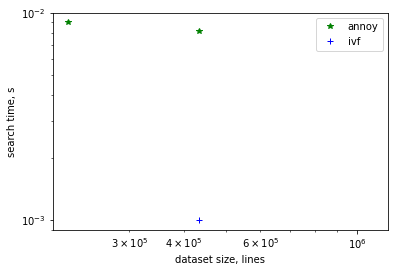

In [66]:
annoy_times = []
annoy_results = []
for ann in annoys:
    start = time()
    res = annoy_search(ann, query)
    stop = time()
    annoy_times.append(stop - start)
    annoy_results.append(res)
    
plt.plot(dataset_sizes[:-1], annoy_times, "g*", label="annoy")
plt.plot(dataset_sizes, ivf_timings, "b+", label="ivf")
plt.xlabel("dataset size, lines")
plt.ylabel("search time, s")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

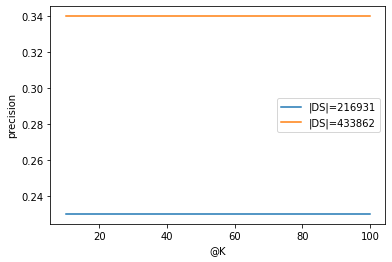

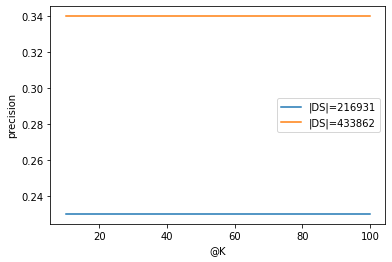

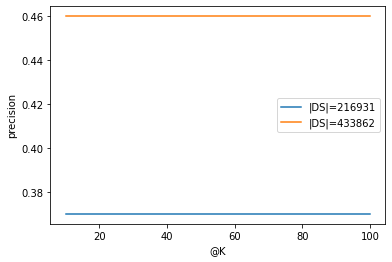

In [67]:
plot_precision(naive_results[:-1], annoy_results)
plot_precision(naive_results[:-1], annoy_results)
plot_precision(naive_results[:-1], annoy_results, c=3)

# HNSW
https://github.com/nmslib/hnswlib. Graph-based library.

In [ ]:
!pip install hnswlib

In [68]:
import hnswlib

def get_hnsw_index(vec_dataset):
    p = hnswlib.Index(space = 'cosine', dim=300)
    p.init_index(max_elements=len(vec_dataset))
    p.add_items(vec_dataset, list(range(len(vec_dataset))))
    return p

In [69]:
hnsws = []

# avoid constructing all except the first first.
for vd in vec_datasets[:1]:
    start = time()
    hnsws.append(get_hnsw_index(vd))
    stop = time()
    print(f"Index construction time: {stop - start:.3f} sec")

Index construction time: 151.282 sec


In [70]:
def hnsw_search(ann, query):
    labels, distances = ann.knn_query(to_vectors([query], silent=True)[0], k=400)
    return list(labels.flatten())

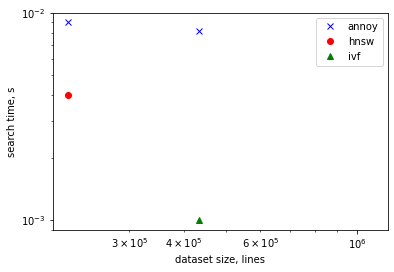

In [71]:
hnsw_times = []
hnsw_results = []
for ann in hnsws:
    start = time()
    res = hnsw_search(ann, query)
    stop = time()
    hnsw_times.append(stop - start)
    hnsw_results.append(res)
    
plt.plot(dataset_sizes[:-1], annoy_times, "bx", label="annoy")
plt.plot(dataset_sizes[:1], hnsw_times, "ro", label="hnsw")
plt.plot(dataset_sizes, ivf_timings, "g^", label="ivf")

plt.xlabel("dataset size, lines")
plt.ylabel("search time, s")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

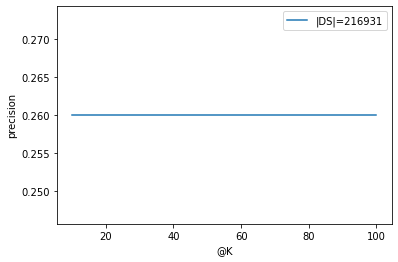

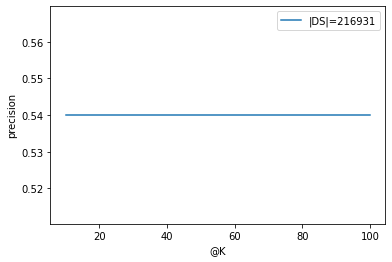

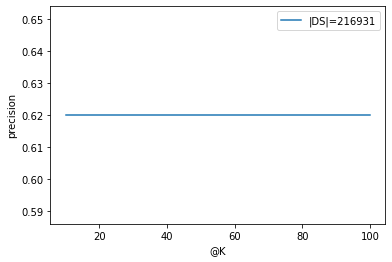

In [73]:
plot_precision(naive_results[:1], hnsw_results, c=1)
plot_precision(naive_results[:1], hnsw_results, c=3)
plot_precision(naive_results[:1], hnsw_results, c=5)